# 4.3 human activity

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV
import warnings
import graphviz
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [3]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count)
feature_dup_df[feature_dup_df['column_index']>1].head()

<bound method DataFrame.count of                                   column_index
column_name                                   
fBodyAcc-bandsEnergy()-1,16                  3
fBodyAcc-bandsEnergy()-1,24                  3
fBodyAcc-bandsEnergy()-1,8                   3
fBodyAcc-bandsEnergy()-17,24                 3
fBodyAcc-bandsEnergy()-17,32                 3
fBodyAcc-bandsEnergy()-25,32                 3
fBodyAcc-bandsEnergy()-25,48                 3
fBodyAcc-bandsEnergy()-33,40                 3
fBodyAcc-bandsEnergy()-33,48                 3
fBodyAcc-bandsEnergy()-41,48                 3
fBodyAcc-bandsEnergy()-49,56                 3
fBodyAcc-bandsEnergy()-49,64                 3
fBodyAcc-bandsEnergy()-57,64                 3
fBodyAcc-bandsEnergy()-9,16                  3
fBodyAccJerk-bandsEnergy()-1,16              3
fBodyAccJerk-bandsEnergy()-1,24              3
fBodyAccJerk-bandsEnergy()-1,8               3
fBodyAccJerk-bandsEnergy()-17,24             3
fBodyAccJerk-bandsEnergy()-

,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [4]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                               if x[1] >0 else x[0] , axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [5]:
def get_human_dataset( ):
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                                  header=None,names=['column_index','column_name'])
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
   
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
 
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [6]:
print('## 학습 피터 데이터셋 info()')
print(X_train.info())

## 학습 피터 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [7]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [8]:
# 예제 반복 시 마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


In [9]:
params = {
    'max_depth' : [ 6, 8 ,10, 12, 16 ,20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.2min finished


GridSearchCV 최고 평균 정확도 수치:0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [10]:
#GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [11]:
max_depths = [ 6, 8 ,10, 12, 16 ,20, 24]
# max_depth 값을 변화 시키면서 그때마다 학습과 테스트 셋에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth , accuracy))

max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575
max_depth = 20 정확도: 0.8548
max_depth = 24 정확도: 0.8548


In [12]:
params = {
    'max_depth' : [ 8 , 12, 16 ,20], 
    'min_samples_split' : [16,24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.4min finished


GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [13]:
best_df_clf = grid_cv.best_estimator_

pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


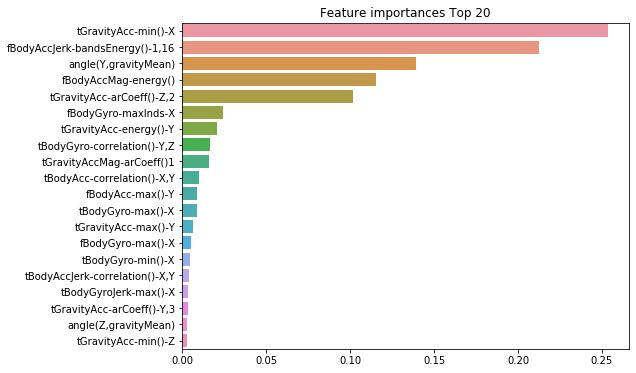

In [14]:
ftr_importances_values = best_df_clf.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

# 4.8 캐글 산텐데르 고객 만족 예측

In [28]:
import matplotlib

cust_df = pd.read_csv("./train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [29]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [30]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format(unsatisfied_cnt / total_cnt))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [31]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [32]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마직막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}', format(X_features.shape))

피처 데이터 shape:{0} (76020, 369)


In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                  test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [38]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

In [39]:
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_train, y_train),(X_test, y_test)])

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

[142]	validation_0-auc:0.861553	validation_1-auc:0.841335
[143]	validation_0-auc:0.861682	validation_1-auc:0.841346
[144]	validation_0-auc:0.86169	validation_1-auc:0.841403
[145]	validation_0-auc:0.861852	validation_1-auc:0.841299
[146]	validation_0-auc:0.861898	validation_1-auc:0.841301
[147]	validation_0-auc:0.861998	validation_1-auc:0.841289
[148]	validation_0-auc:0.862068	validation_1-auc:0.84135
[149]	validation_0-auc:0.862132	validation_1-auc:0.841444
[150]	validation_0-auc:0.862236	validation_1-auc:0.841409
[151]	validation_0-auc:0.862314	validation_1-auc:0.841459
[152]	validation_0-auc:0.862584	validation_1-auc:0.841456
[153]	validation_0-auc:0.862843	validation_1-auc:0.841483
[154]	validation_0-auc:0.863033	validation_1-auc:0.841493
[155]	validation_0-auc:0.863132	validation_1-auc:0.841534
[156]	validation_0-auc:0.863423	validation_1-auc:0.841728
[157]	validation_0-auc:0.863578	validation_1-auc:0.841712
[158]	validation_0-auc:0.863872	validation_1-auc:0.841677
[159]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=156,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [40]:
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:,.4f}'.format(xgb_roc_score))

ROC AUC: 0.8419


In [44]:
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max-depth':[5,7], 'min_child_weight':[1,3],'colsample_bytree':[0.5, 0.75]}

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])
                    
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
                    
xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.689367	validation_1-auc:0.701839
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.792336	validation_1-auc:0.798398
[2]	validation_0-auc:0.789095	validation_1-auc:0.800069
[3]	validation_0-auc:0.793323	validation_1-auc:0.805475
[4]	validation_0-auc:0.802541	validation_1-auc:0.81157
[5]	validation_0-auc:0.799073	validation_1-auc:0.8093
[6]	validation_0-auc:0.798946	validation_1-auc:0.809122
[7]	validation_0-auc:0.803144	validation_1-auc:0.813628
[8]	validation_0-auc:0.807818	validation_1-auc:0.815817
[9]	validation_0-auc:0.809204	validation_1-auc:0.817484
[10]	validation_0-auc:0.809742	validation_1-auc:0.817683
[11]	validation_0-auc:0.811012	validation_1-auc:0.819432
[12]	validation_0-auc:0.817156	validation_1-auc:0.82296
[13]	validation_0-auc:0.811633	validation_1-auc:0.817751
[14]	validation_0-auc:0.812406	validation_1-auc:0.818463
[1

[39]	validation_0-auc:0.838957	validation_1-auc:0.836548
[40]	validation_0-auc:0.838437	validation_1-auc:0.835592
[41]	validation_0-auc:0.838375	validation_1-auc:0.835492
[42]	validation_0-auc:0.839687	validation_1-auc:0.8365
[43]	validation_0-auc:0.840147	validation_1-auc:0.836757
[44]	validation_0-auc:0.840741	validation_1-auc:0.837475
[45]	validation_0-auc:0.840981	validation_1-auc:0.837572
[46]	validation_0-auc:0.841785	validation_1-auc:0.838342
[47]	validation_0-auc:0.842276	validation_1-auc:0.83872
[48]	validation_0-auc:0.842662	validation_1-auc:0.839003
[49]	validation_0-auc:0.843227	validation_1-auc:0.839548
[50]	validation_0-auc:0.843455	validation_1-auc:0.83968
[51]	validation_0-auc:0.844299	validation_1-auc:0.84021
[52]	validation_0-auc:0.844609	validation_1-auc:0.840496
[53]	validation_0-auc:0.845262	validation_1-auc:0.840571
[54]	validation_0-auc:0.845416	validation_1-auc:0.840493
[55]	validation_0-auc:0.845702	validation_1-auc:0.84039
[56]	validation_0-auc:0.846026	valida

[81]	validation_0-auc:0.851127	validation_1-auc:0.842277
[82]	validation_0-auc:0.85137	validation_1-auc:0.842363
[83]	validation_0-auc:0.85151	validation_1-auc:0.842491
[84]	validation_0-auc:0.851684	validation_1-auc:0.842887
[85]	validation_0-auc:0.851851	validation_1-auc:0.842919
[86]	validation_0-auc:0.851996	validation_1-auc:0.842901
[87]	validation_0-auc:0.852087	validation_1-auc:0.842977
[88]	validation_0-auc:0.852192	validation_1-auc:0.842842
[89]	validation_0-auc:0.852392	validation_1-auc:0.842947
[90]	validation_0-auc:0.852441	validation_1-auc:0.842877
[91]	validation_0-auc:0.852622	validation_1-auc:0.842685
[92]	validation_0-auc:0.852616	validation_1-auc:0.842668
[93]	validation_0-auc:0.852655	validation_1-auc:0.842599
[94]	validation_0-auc:0.852831	validation_1-auc:0.842427
[95]	validation_0-auc:0.85298	validation_1-auc:0.842757
[96]	validation_0-auc:0.853051	validation_1-auc:0.842781
[97]	validation_0-auc:0.853165	validation_1-auc:0.842958
[98]	validation_0-auc:0.853288	val

[21]	validation_0-auc:0.829065	validation_1-auc:0.828428
[22]	validation_0-auc:0.826142	validation_1-auc:0.826309
[23]	validation_0-auc:0.829564	validation_1-auc:0.82796
[24]	validation_0-auc:0.83113	validation_1-auc:0.830098
[25]	validation_0-auc:0.831149	validation_1-auc:0.829702
[26]	validation_0-auc:0.829817	validation_1-auc:0.82808
[27]	validation_0-auc:0.83187	validation_1-auc:0.830703
[28]	validation_0-auc:0.833783	validation_1-auc:0.832396
[29]	validation_0-auc:0.833591	validation_1-auc:0.832109
[30]	validation_0-auc:0.834405	validation_1-auc:0.834281
[31]	validation_0-auc:0.835512	validation_1-auc:0.835063
[32]	validation_0-auc:0.835734	validation_1-auc:0.835692
[33]	validation_0-auc:0.835527	validation_1-auc:0.834611
[34]	validation_0-auc:0.835246	validation_1-auc:0.833436
[35]	validation_0-auc:0.837285	validation_1-auc:0.834973
[36]	validation_0-auc:0.837962	validation_1-auc:0.835366
[37]	validation_0-auc:0.838313	validation_1-auc:0.835824
[38]	validation_0-auc:0.838339	vali

[63]	validation_0-auc:0.847043	validation_1-auc:0.842321
[64]	validation_0-auc:0.847071	validation_1-auc:0.842109
[65]	validation_0-auc:0.847381	validation_1-auc:0.842188
[66]	validation_0-auc:0.84767	validation_1-auc:0.842122
[67]	validation_0-auc:0.847883	validation_1-auc:0.842023
[68]	validation_0-auc:0.848107	validation_1-auc:0.84207
[69]	validation_0-auc:0.848277	validation_1-auc:0.842047
[70]	validation_0-auc:0.84844	validation_1-auc:0.842073
[71]	validation_0-auc:0.848618	validation_1-auc:0.842022
[72]	validation_0-auc:0.848749	validation_1-auc:0.842004
[73]	validation_0-auc:0.849011	validation_1-auc:0.841921
[74]	validation_0-auc:0.849075	validation_1-auc:0.842032
[75]	validation_0-auc:0.849483	validation_1-auc:0.84209
[76]	validation_0-auc:0.849639	validation_1-auc:0.8421
[77]	validation_0-auc:0.849708	validation_1-auc:0.842168
[78]	validation_0-auc:0.849853	validation_1-auc:0.842387
[79]	validation_0-auc:0.850115	validation_1-auc:0.842346
[80]	validation_0-auc:0.850292	valida

[2]	validation_0-auc:0.792079	validation_1-auc:0.803452
[3]	validation_0-auc:0.799379	validation_1-auc:0.809092
[4]	validation_0-auc:0.809843	validation_1-auc:0.818448
[5]	validation_0-auc:0.808251	validation_1-auc:0.814711
[6]	validation_0-auc:0.807324	validation_1-auc:0.813438
[7]	validation_0-auc:0.810433	validation_1-auc:0.81874
[8]	validation_0-auc:0.813825	validation_1-auc:0.821237
[9]	validation_0-auc:0.815513	validation_1-auc:0.82221
[10]	validation_0-auc:0.817009	validation_1-auc:0.823693
[11]	validation_0-auc:0.823473	validation_1-auc:0.827162
[12]	validation_0-auc:0.824338	validation_1-auc:0.828069
[13]	validation_0-auc:0.820237	validation_1-auc:0.82299
[14]	validation_0-auc:0.818853	validation_1-auc:0.820615
[15]	validation_0-auc:0.822523	validation_1-auc:0.822851
[16]	validation_0-auc:0.825178	validation_1-auc:0.826246
[17]	validation_0-auc:0.826002	validation_1-auc:0.827556
[18]	validation_0-auc:0.827711	validation_1-auc:0.828885
[19]	validation_0-auc:0.827722	validation_

[44]	validation_0-auc:0.840383	validation_1-auc:0.838799
[45]	validation_0-auc:0.840819	validation_1-auc:0.838744
[46]	validation_0-auc:0.841572	validation_1-auc:0.839249
[47]	validation_0-auc:0.842049	validation_1-auc:0.839495
[48]	validation_0-auc:0.842412	validation_1-auc:0.839203
[49]	validation_0-auc:0.842612	validation_1-auc:0.83961
[50]	validation_0-auc:0.842868	validation_1-auc:0.839782
[51]	validation_0-auc:0.84365	validation_1-auc:0.840231
[52]	validation_0-auc:0.844414	validation_1-auc:0.840923
[53]	validation_0-auc:0.844599	validation_1-auc:0.841076
[54]	validation_0-auc:0.845027	validation_1-auc:0.84118
[55]	validation_0-auc:0.845272	validation_1-auc:0.841421
[56]	validation_0-auc:0.845707	validation_1-auc:0.841445
[57]	validation_0-auc:0.84585	validation_1-auc:0.841554
[58]	validation_0-auc:0.846166	validation_1-auc:0.84175
[59]	validation_0-auc:0.846284	validation_1-auc:0.841811
[60]	validation_0-auc:0.846626	validation_1-auc:0.842171
[61]	validation_0-auc:0.846915	valid

[86]	validation_0-auc:0.849588	validation_1-auc:0.83964
[87]	validation_0-auc:0.849666	validation_1-auc:0.839682
[88]	validation_0-auc:0.849807	validation_1-auc:0.839791
[89]	validation_0-auc:0.850037	validation_1-auc:0.839554
[90]	validation_0-auc:0.850153	validation_1-auc:0.839849
[91]	validation_0-auc:0.850224	validation_1-auc:0.839795
[92]	validation_0-auc:0.850244	validation_1-auc:0.839727
[93]	validation_0-auc:0.850249	validation_1-auc:0.839659
[94]	validation_0-auc:0.850331	validation_1-auc:0.839677
[95]	validation_0-auc:0.85041	validation_1-auc:0.83974
[96]	validation_0-auc:0.850418	validation_1-auc:0.839669
[97]	validation_0-auc:0.850495	validation_1-auc:0.839773
[98]	validation_0-auc:0.850603	validation_1-auc:0.83975
[99]	validation_0-auc:0.850695	validation_1-auc:0.839832
[0]	validation_0-auc:0.713647	validation_1-auc:0.723399
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 r

[26]	validation_0-auc:0.829948	validation_1-auc:0.833977
[27]	validation_0-auc:0.831635	validation_1-auc:0.835158
[28]	validation_0-auc:0.833157	validation_1-auc:0.835658
[29]	validation_0-auc:0.832703	validation_1-auc:0.836426
[30]	validation_0-auc:0.833745	validation_1-auc:0.836424
[31]	validation_0-auc:0.834334	validation_1-auc:0.836487
[32]	validation_0-auc:0.835161	validation_1-auc:0.836712
[33]	validation_0-auc:0.835458	validation_1-auc:0.836605
[34]	validation_0-auc:0.835558	validation_1-auc:0.835998
[35]	validation_0-auc:0.836361	validation_1-auc:0.83629
[36]	validation_0-auc:0.836651	validation_1-auc:0.836032
[37]	validation_0-auc:0.836913	validation_1-auc:0.836287
[38]	validation_0-auc:0.837031	validation_1-auc:0.836902
[39]	validation_0-auc:0.83703	validation_1-auc:0.837177
[40]	validation_0-auc:0.837477	validation_1-auc:0.837454
[41]	validation_0-auc:0.837176	validation_1-auc:0.837539
[42]	validation_0-auc:0.838463	validation_1-auc:0.838081
[43]	validation_0-auc:0.839023	va

[68]	validation_0-auc:0.84643	validation_1-auc:0.838458
[69]	validation_0-auc:0.846711	validation_1-auc:0.838761
[70]	validation_0-auc:0.846921	validation_1-auc:0.838751
[71]	validation_0-auc:0.847065	validation_1-auc:0.838726
[72]	validation_0-auc:0.8472	validation_1-auc:0.838559
[73]	validation_0-auc:0.84746	validation_1-auc:0.838676
[74]	validation_0-auc:0.847677	validation_1-auc:0.838808
[75]	validation_0-auc:0.847986	validation_1-auc:0.838596
[76]	validation_0-auc:0.84834	validation_1-auc:0.838763
[77]	validation_0-auc:0.848587	validation_1-auc:0.838655
[78]	validation_0-auc:0.848738	validation_1-auc:0.838662
[79]	validation_0-auc:0.848928	validation_1-auc:0.838766
[80]	validation_0-auc:0.849273	validation_1-auc:0.839148
[81]	validation_0-auc:0.849446	validation_1-auc:0.83897
[82]	validation_0-auc:0.849557	validation_1-auc:0.839113
[83]	validation_0-auc:0.849647	validation_1-auc:0.839185
[84]	validation_0-auc:0.849699	validation_1-auc:0.839199
[85]	validation_0-auc:0.849901	valida

[8]	validation_0-auc:0.815348	validation_1-auc:0.817076
[9]	validation_0-auc:0.817491	validation_1-auc:0.820466
[10]	validation_0-auc:0.81751	validation_1-auc:0.820348
[11]	validation_0-auc:0.822082	validation_1-auc:0.822746
[12]	validation_0-auc:0.822403	validation_1-auc:0.822436
[13]	validation_0-auc:0.825908	validation_1-auc:0.827108
[14]	validation_0-auc:0.826749	validation_1-auc:0.827037
[15]	validation_0-auc:0.8249	validation_1-auc:0.824493
[16]	validation_0-auc:0.825201	validation_1-auc:0.823952
[17]	validation_0-auc:0.82756	validation_1-auc:0.827008
[18]	validation_0-auc:0.827559	validation_1-auc:0.827471
[19]	validation_0-auc:0.828591	validation_1-auc:0.829599
[20]	validation_0-auc:0.828555	validation_1-auc:0.829542
[21]	validation_0-auc:0.829131	validation_1-auc:0.830332
[22]	validation_0-auc:0.829928	validation_1-auc:0.831426
[23]	validation_0-auc:0.830279	validation_1-auc:0.831216
[24]	validation_0-auc:0.830432	validation_1-auc:0.83145
[25]	validation_0-auc:0.831506	validat

[50]	validation_0-auc:0.840621	validation_1-auc:0.837256
[51]	validation_0-auc:0.841124	validation_1-auc:0.837633
[52]	validation_0-auc:0.841327	validation_1-auc:0.837541
[53]	validation_0-auc:0.84169	validation_1-auc:0.837622
[54]	validation_0-auc:0.842337	validation_1-auc:0.837839
[55]	validation_0-auc:0.842557	validation_1-auc:0.838337
[56]	validation_0-auc:0.842875	validation_1-auc:0.838216
[57]	validation_0-auc:0.842953	validation_1-auc:0.838113
[58]	validation_0-auc:0.843319	validation_1-auc:0.838409
[59]	validation_0-auc:0.843927	validation_1-auc:0.838761
[60]	validation_0-auc:0.844154	validation_1-auc:0.838561
[61]	validation_0-auc:0.844387	validation_1-auc:0.838818
[62]	validation_0-auc:0.844827	validation_1-auc:0.839094
[63]	validation_0-auc:0.845334	validation_1-auc:0.839234
[64]	validation_0-auc:0.845632	validation_1-auc:0.839088
[65]	validation_0-auc:0.84603	validation_1-auc:0.839163
[66]	validation_0-auc:0.846377	validation_1-auc:0.839283
[67]	validation_0-auc:0.846628	va

[92]	validation_0-auc:0.851619	validation_1-auc:0.841537
[93]	validation_0-auc:0.851686	validation_1-auc:0.841603
[94]	validation_0-auc:0.851764	validation_1-auc:0.841632
[95]	validation_0-auc:0.851845	validation_1-auc:0.841742
[96]	validation_0-auc:0.852078	validation_1-auc:0.841958
[97]	validation_0-auc:0.852113	validation_1-auc:0.841988
[98]	validation_0-auc:0.852178	validation_1-auc:0.842066
[99]	validation_0-auc:0.852251	validation_1-auc:0.842109
[0]	validation_0-auc:0.800782	validation_1-auc:0.809268
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.815599	validation_1-auc:0.817023
[2]	validation_0-auc:0.816329	validation_1-auc:0.816732
[3]	validation_0-auc:0.815128	validation_1-auc:0.816144
[4]	validation_0-auc:0.817997	validation_1-auc:0.818384
[5]	validation_0-auc:0.8164	validation_1-auc:0.816058
[6]	validation_0-auc:0.816223	validation_1-auc:0.8170

[32]	validation_0-auc:0.834094	validation_1-auc:0.832685
[33]	validation_0-auc:0.835337	validation_1-auc:0.833151
[34]	validation_0-auc:0.835352	validation_1-auc:0.83357
[35]	validation_0-auc:0.83561	validation_1-auc:0.833786
[36]	validation_0-auc:0.835872	validation_1-auc:0.834308
[37]	validation_0-auc:0.836302	validation_1-auc:0.834542
[38]	validation_0-auc:0.836658	validation_1-auc:0.834353
[39]	validation_0-auc:0.83662	validation_1-auc:0.834345
[40]	validation_0-auc:0.837101	validation_1-auc:0.834639
[41]	validation_0-auc:0.8375	validation_1-auc:0.834854
[42]	validation_0-auc:0.837677	validation_1-auc:0.834682
[43]	validation_0-auc:0.838094	validation_1-auc:0.835127
[44]	validation_0-auc:0.838121	validation_1-auc:0.835184
[45]	validation_0-auc:0.838644	validation_1-auc:0.835636
[46]	validation_0-auc:0.838995	validation_1-auc:0.835582
[47]	validation_0-auc:0.839712	validation_1-auc:0.835891
[48]	validation_0-auc:0.840131	validation_1-auc:0.836302
[49]	validation_0-auc:0.84023	valida

[74]	validation_0-auc:0.849414	validation_1-auc:0.840533
[75]	validation_0-auc:0.849516	validation_1-auc:0.840584
[76]	validation_0-auc:0.849669	validation_1-auc:0.840687
[77]	validation_0-auc:0.849966	validation_1-auc:0.840682
[78]	validation_0-auc:0.850046	validation_1-auc:0.840555
[79]	validation_0-auc:0.850347	validation_1-auc:0.840872
[80]	validation_0-auc:0.850579	validation_1-auc:0.840919
[81]	validation_0-auc:0.85072	validation_1-auc:0.841115
[82]	validation_0-auc:0.850926	validation_1-auc:0.841249
[83]	validation_0-auc:0.851123	validation_1-auc:0.841313
[84]	validation_0-auc:0.851308	validation_1-auc:0.841389
[85]	validation_0-auc:0.85143	validation_1-auc:0.841417
[86]	validation_0-auc:0.851568	validation_1-auc:0.841507
[87]	validation_0-auc:0.851676	validation_1-auc:0.841637
[88]	validation_0-auc:0.851773	validation_1-auc:0.841685
[89]	validation_0-auc:0.851905	validation_1-auc:0.841819
[90]	validation_0-auc:0.851984	validation_1-auc:0.841878
[91]	validation_0-auc:0.852136	va

[14]	validation_0-auc:0.8213	validation_1-auc:0.825114
[15]	validation_0-auc:0.823833	validation_1-auc:0.826494
[16]	validation_0-auc:0.823396	validation_1-auc:0.826374
[17]	validation_0-auc:0.824765	validation_1-auc:0.826607
[18]	validation_0-auc:0.825373	validation_1-auc:0.827321
[19]	validation_0-auc:0.825665	validation_1-auc:0.829665
[20]	validation_0-auc:0.828034	validation_1-auc:0.830878
[21]	validation_0-auc:0.829073	validation_1-auc:0.830622
[22]	validation_0-auc:0.830217	validation_1-auc:0.83169
[23]	validation_0-auc:0.830796	validation_1-auc:0.832771
[24]	validation_0-auc:0.830507	validation_1-auc:0.83201
[25]	validation_0-auc:0.830809	validation_1-auc:0.831871
[26]	validation_0-auc:0.831192	validation_1-auc:0.831615
[27]	validation_0-auc:0.831667	validation_1-auc:0.832085
[28]	validation_0-auc:0.831504	validation_1-auc:0.832085
[29]	validation_0-auc:0.832822	validation_1-auc:0.832886
[30]	validation_0-auc:0.833241	validation_1-auc:0.83381
[31]	validation_0-auc:0.833515	valid

[56]	validation_0-auc:0.844427	validation_1-auc:0.839058
[57]	validation_0-auc:0.844759	validation_1-auc:0.838937
[58]	validation_0-auc:0.845183	validation_1-auc:0.83905
[59]	validation_0-auc:0.845709	validation_1-auc:0.839276
[60]	validation_0-auc:0.84603	validation_1-auc:0.839488
[61]	validation_0-auc:0.846368	validation_1-auc:0.839428
[62]	validation_0-auc:0.846491	validation_1-auc:0.839565
[63]	validation_0-auc:0.846908	validation_1-auc:0.839536
[64]	validation_0-auc:0.847141	validation_1-auc:0.839623
[65]	validation_0-auc:0.8472	validation_1-auc:0.839455
[66]	validation_0-auc:0.847397	validation_1-auc:0.83928
[67]	validation_0-auc:0.847802	validation_1-auc:0.83918
[68]	validation_0-auc:0.848016	validation_1-auc:0.839337
[69]	validation_0-auc:0.848027	validation_1-auc:0.839133
[70]	validation_0-auc:0.848114	validation_1-auc:0.839165
[71]	validation_0-auc:0.848247	validation_1-auc:0.83945
[72]	validation_0-auc:0.848424	validation_1-auc:0.839806
[73]	validation_0-auc:0.848762	validat

[98]	validation_0-auc:0.851802	validation_1-auc:0.841789
[99]	validation_0-auc:0.851914	validation_1-auc:0.841764
[0]	validation_0-auc:0.708133	validation_1-auc:0.719942
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.800655	validation_1-auc:0.807611
[2]	validation_0-auc:0.793102	validation_1-auc:0.801841
[3]	validation_0-auc:0.798955	validation_1-auc:0.807507
[4]	validation_0-auc:0.807326	validation_1-auc:0.815866
[5]	validation_0-auc:0.802612	validation_1-auc:0.811119
[6]	validation_0-auc:0.804858	validation_1-auc:0.812899
[7]	validation_0-auc:0.81005	validation_1-auc:0.816866
[8]	validation_0-auc:0.813159	validation_1-auc:0.819969
[9]	validation_0-auc:0.814513	validation_1-auc:0.820787
[10]	validation_0-auc:0.815397	validation_1-auc:0.821358
[11]	validation_0-auc:0.819956	validation_1-auc:0.825203
[12]	validation_0-auc:0.820481	validation_1-auc:0.825492

In [47]:
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,
                       min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_set=[(X_train, y_train), (X_test, y_test)])
                                                                    
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))                             


[0]	validation_0-error:0.038641	validation_1-error:0.042094
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 200 rounds.
[1]	validation_0-error:0.038658	validation_1-error:0.04216
[2]	validation_0-error:0.038542	validation_1-error:0.042094
[3]	validation_0-error:0.038625	validation_1-error:0.041897
[4]	validation_0-error:0.038559	validation_1-error:0.042028
[5]	validation_0-error:0.038641	validation_1-error:0.042028
[6]	validation_0-error:0.038658	validation_1-error:0.041897
[7]	validation_0-error:0.038592	validation_1-error:0.041963
[8]	validation_0-error:0.038723	validation_1-error:0.041897
[9]	validation_0-error:0.038625	validation_1-error:0.041963
[10]	validation_0-error:0.038674	validation_1-error:0.041831
[11]	validation_0-error:0.038641	validation_1-error:0.041831
[12]	validation_0-error:0.03869	validation_1-error:0.041831
[13]	validation_0-error:0.038592	validation_1-error:0.041

[133]	validation_0-error:0.038279	validation_1-error:0.0417
[134]	validation_0-error:0.038247	validation_1-error:0.0417
[135]	validation_0-error:0.038279	validation_1-error:0.0417
[136]	validation_0-error:0.038279	validation_1-error:0.0417
[137]	validation_0-error:0.038263	validation_1-error:0.0417
[138]	validation_0-error:0.038263	validation_1-error:0.0417
[139]	validation_0-error:0.038263	validation_1-error:0.0417
[140]	validation_0-error:0.038263	validation_1-error:0.0417
[141]	validation_0-error:0.038263	validation_1-error:0.0417
[142]	validation_0-error:0.038263	validation_1-error:0.0417
[143]	validation_0-error:0.038247	validation_1-error:0.0417
[144]	validation_0-error:0.03823	validation_1-error:0.0417
[145]	validation_0-error:0.03823	validation_1-error:0.0417
[146]	validation_0-error:0.038214	validation_1-error:0.0417
[147]	validation_0-error:0.038214	validation_1-error:0.0417
[148]	validation_0-error:0.038181	validation_1-error:0.0417
[149]	validation_0-error:0.038181	validati

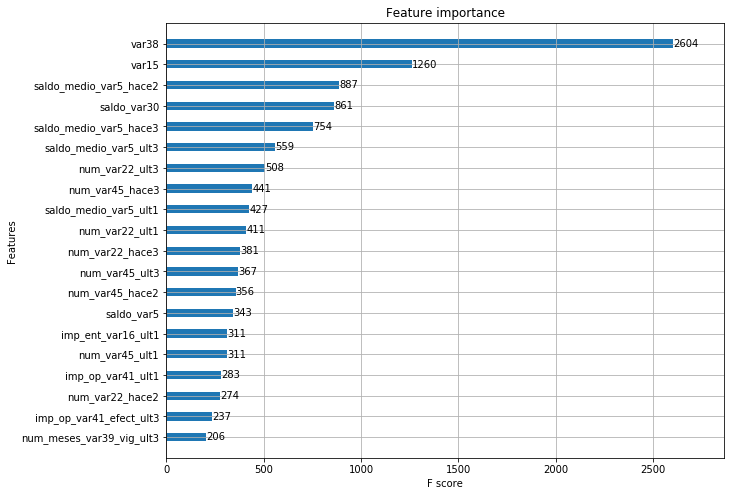

In [50]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)